# Drop-out experiments

# Imports and Load Individual Models

In [1]:
# imports
# basic
import os
import pandas as pd
import re
# cobra
from cobra.io import read_sbml_model
from cobra.flux_analysis import pfba
from cobra.medium import minimal_medium
from cobra.exceptions import Infeasible, OptimizationError
from micom import Community
# plots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import seaborn as sns
import matplotlib.colors as mcolors
from micom.problems import cooperative_tradeoff

from Scripts.functions import test_medium

In [2]:
# Load SBML Models
models_path = "../Models/10_duplicate_removal/"
models = {}
for model_name in (f for f in os.listdir(models_path) if f.endswith(".xml")):
    model = read_sbml_model(f"{models_path}/{model_name}")
    model.solver = "cplex"
    name = str(model_name[:3])
    models[name] = model

models = {key: models[key] for key in sorted(models.keys())}  # sorts the dictionary alphabetically
AA1, AA2, AA3, AA4, AA5, AA6, AA7 = [models[f"AA{i}"] for i in range(1, 8)]

Restricted license - for non-production use only - expires 2026-11-23


# Functions

In [33]:
def change_medium(model, medium_dict, syncom="yes"):
    # when I read the csv files with medium info it is saved as a dataframe, but i want a dict
    if isinstance(medium_dict, pd.DataFrame):
        medium_dict = dict(zip(medium_dict.reaction, medium_dict.bound))

    # we only have community models, so we need to adjust the medium suffices
    medium_dict = {k.removesuffix('_e') + '_m' if k.endswith('_e') else k: v for k, v in medium_dict.items()}

    # Only include reactions that are in the model
    valid_medium = {
        rxn: bound for rxn, bound in medium_dict.items()
        if rxn in model.reactions
    }
    model.medium = valid_medium
    #print(valid_medium)

In [34]:
def community_pfba(com_model, medium):
    with model:
        change_medium(com_model, medium)
        try:
            fluxes = com_model.cooperative_tradeoff(pfba=True, fluxes=True).fluxes.transpose()
        except (Infeasible, OptimizationError):
            print(f"Model {com_model.id} is infeasible.")
            return None, None

        growth = fluxes[fluxes.index.str.contains("Growth")].transpose()
        growth = growth[~ growth.index.str.contains("medium")]
        growth.index.name = "model"
        growth = growth["Growth"]
        #print(com_model.id, growth)

        return fluxes, growth

In [8]:
def safe_parse(x):
    if x.startswith('['):
        # Add quotes around items inside brackets if they're not already quoted
        items = re.findall(r'\w+__?\w*', x)
        return items
    else:
        return x

In [50]:
# changes medium, does pfba and returns growth rate
def test_medium(model, medium_dict, frac=1):
    with model:
        change_medium(model, medium_dict)
        try:
            #print(model.medium)
            solution = model.cooperative_tradeoff(fluxes=True, pfba=True, fraction=frac).fluxes.transpose()
            growth = solution[solution.index.str.contains("Growth")].transpose()
            growth = growth[~ growth.index.str.contains("medium")]
            growth.index.name = "model"
            growth = growth["Growth"]
            return growth
        except Infeasible:
            #print(f"Model {model.id} is infeasible with the given medium.")
            return None
        except OptimizationError as e:
            #print(f"OptimizationError for model {model.id}: {e}")
            return None


# takes result dict from "create medium" to create a heatmap
def visualise_heatmap_medium(results):
    # Convert the results dictionary to a DataFrame
    df = pd.DataFrame(results).T  # Transpose the DataFrame
    df = df.apply(pd.to_numeric, errors='coerce') # take care of non-numerical values
    # Create a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Growth Value'})
    plt.title("Growth Values Heatmap")
    plt.xlabel("Model ID")
    plt.ylabel("Carbon Source")
    plt.show()


# takes a list with different carbon sources (EX reactions) and a list with reactions that together form a minimal medium
# each carbon source is coupled with the minimal medium one at the time and these media are then testes for growth
# model_dict contain the models where the media are tested on;
# it is visualised through a heatmap
def create_medium(carbon_list, minimal_list, model_dict, medium_uptake_bound, carbon_only = False):
    # Flatten the carbon_list for consistent keys
    flattened_sources = [item[0] if isinstance(item, list) else item for item in carbon_list]
    results = {carbon[3:-2]: {model.id: None for model in model_dict.values()} for carbon in flattened_sources}

    for carbon in carbon_list:
        # Standardize the carbon key (used to index the results dict)
        if isinstance(carbon, list):
            carbon_key = carbon[0][3:-2]
            new_medium = minimal_list + carbon
        else:
            carbon_key = carbon[3:-2]
            new_medium = minimal_list + [carbon]

        # define uptake bound here (this has big impact on how much biomass can be produced)
        # med_dict = {new_medium[i]: medium_uptake_bound for i in range(len(new_medium))}

        #####
        if carbon_only:
            carbon_sources = carbon if isinstance(carbon, list) else [carbon]
            med_dict = {
                met: medium_uptake_bound if met in carbon_sources else 1000
                for met in new_medium}
        else:
            med_dict = {met: medium_uptake_bound for met in new_medium}
        #####

        for model in model_dict.values():
            print(model.id)
            growth_val = test_medium(model, med_dict)
            # print(growth_val)
            if isinstance(growth_val, pd.Series):
                #print(carbon, growth_val)
                growth_val= pd.DataFrame(growth_val).iloc[:, 0].sum()/7
            results[carbon_key][model.id] = growth_val
            print(carbon_key, growth_val)
        #print("-----")
    visualise_heatmap_medium(results)

# Medium

In [9]:
m9 = pd.read_csv("../Datasets/Medium/medium_M9.csv", sep=";")
m9_rxn = list(m9["reaction"])

In [10]:
medium_combined = pd.read_csv("../Datasets/Medium/medium_ARE_M9.csv", sep=";", quotechar='"')
combined_med_wo_bz = medium_combined[medium_combined['reaction'] != 'EX_bz_e']

In [11]:
mre_naveed = pd.read_csv("../Datasets/Medium/medium_ARE_Naveed.csv", sep=";")

In [12]:
ecoplate = pd.read_csv("../Datasets/Medium/medium_ecoplate_carbon.csv", sep=";", quotechar='"')
ecoplate_rxns = [safe_parse(x) for x in ecoplate["reaction"]]

# Create C7 Community Model with MICOM

In [13]:
taxonomy = pd.read_csv("../Datasets/community_model.csv", sep=";")
syncom = Community(taxonomy.iloc[:, :-1], name="synthetic seven member bacterial community", id="C7", solver="cplex")

Output()

In [14]:
# change lower bound of Exchange reactions (EX between bacteria and medium)
for rxn in syncom.reactions.query("^EX_"):
    rxn.lower_bound = -1000

# Create Drop-out Communities
From our C7 community we want to exclude one bacterium at a time amking it a C6 community

In [15]:
syncoms = {}

for i in range(len(taxonomy)):
    cut_tax = taxonomy.drop(index=taxonomy.index[i])
    name = f"syncom_drop{i+1}"

    com = Community(
        cut_tax.iloc[:, :-1],
        name="synthetic six member bacterial community",
        id=name,
        solver="cplex")

    # Set EX reaction bounds for this syncom
    for rxn in com.reactions.query("^EX_"):
        rxn.lower_bound = -1000  # make exchange freely available

    syncoms[name] = com

S1, S2, S3, S4, S5, S6, S7 = [syncoms[f"syncom_drop{i+1}"] for i in range(7)]

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [16]:
all_models = {**syncoms, 'C7_Community': syncom}

# Growth for all drop-out syncoms

In [17]:
# Include full 7-member community
growth_data = {}

for name, syncom in all_models.items():  # <-- now includes C7_Community
    _, growth = community_pfba(syncom, combined_med_wo_bz)
    if growth is not None:
        growth_data[name] = growth

# Combine into DataFrame
growth_df = pd.DataFrame(growth_data).transpose()

epsilon = 1e-6
growth_df = growth_df.applymap(lambda x: 0 if abs(x) < epsilon else x)
# sort to put full community on top
growth_df = growth_df.sort_index(key=lambda x: x.str.replace("C7_Community", "0"), axis=0)

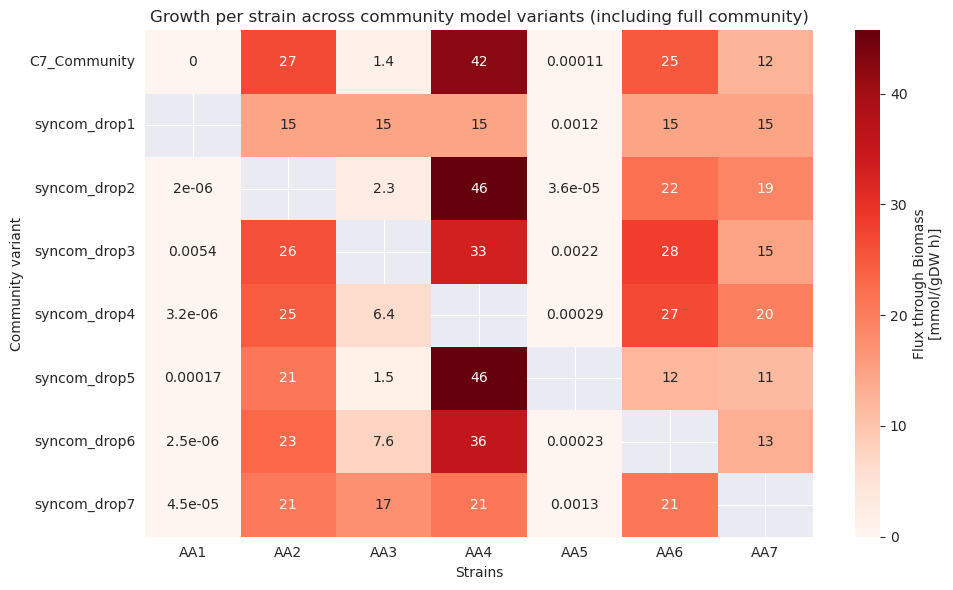

In [18]:
# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    growth_df,
    annot=True,
    cmap="Reds",
    cbar_kws={'label': 'Flux through Biomass\n[mmol/(gDW h)]'}
)
plt.title("Growth per strain across community model variants (including full community)")
plt.xlabel("Strains")
plt.ylabel("Community variant")
plt.tight_layout()
plt.show()


# Substrate Utilisation (BIOLOG Ecoplate)

def create_medium(carbon_list, minimal_list, model_dict, medium_uptake_bound, carbon_only = False):

In [ ]:
create_medium(ecoplate_rxns, m9_rxn, all_models, 1000)
# takes around 9min

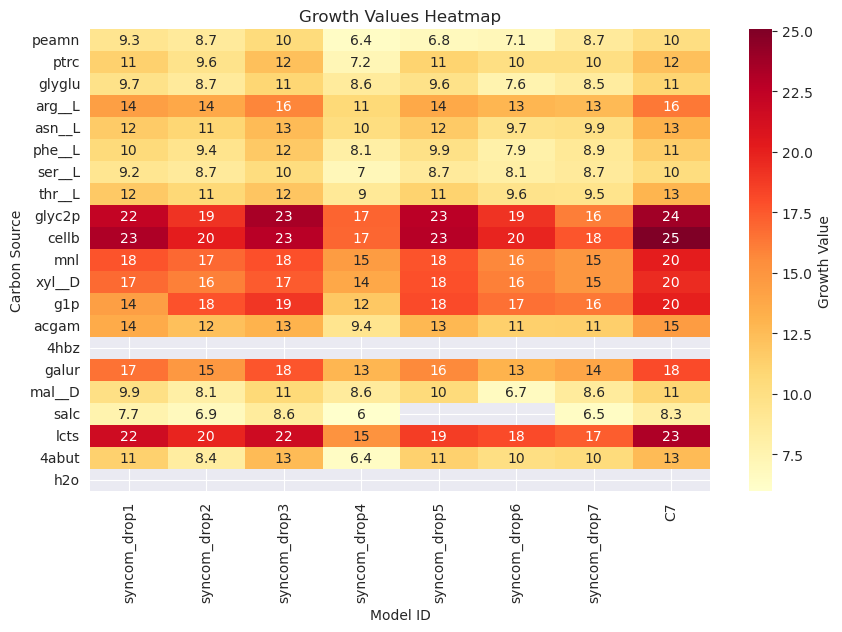

In [48]:
df = pd.DataFrame(res).T  # Transpose the DataFrame
df = df.apply(pd.to_numeric, errors='coerce')

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="YlOrRd", cbar_kws={'label': 'Growth Value'})
plt.title("Growth Values Heatmap")
plt.xlabel("Model ID")
plt.ylabel("Carbon Source")
plt.show()